# Assignment 4
Sander Broos & Nick van Santen

In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Run cell to increase font sizes. Useful when saving plots
SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (8,6)

### Classes

In [89]:
class Cellular_plots_model:

    def __init__(self, n_steps, n_types, n_cells, nx=40, T=1, k=0.5, lamda=1, equilibrium_area=5, collect_data_steps=10000):

        self.n_steps = n_steps
        self.n_types = n_types
        self.n_cells = n_cells

        self.nx = nx
        self.T = T
        self.k = k
        self.lamda = lamda
        self.equilibrium_area = equilibrium_area
        
        self.initialize_grid_fixed()
        self.initialize_cell_sizes()

        self.step = 0

        if n_types != 3:
            raise Exception("Error: Current J function only accepts 3 types: the M type and two others")

        # M=0, d=1, l=2 
        # Each row has index 0: type_min, index 1: type_max, index 2: J value
        # J values obtained from Glazer 2013. The report did not specify the
        # J value for M, M 
        self.J_table = {
            frozenset((0,0)): 0, 
            frozenset((1,1)): 2,
            frozenset((1,2)): 11,
            frozenset((2,2)): 14,
            frozenset((0,1)): 16,
            frozenset((0,2)): 16,
        }

        self.initialize_rands()

        self.collect_data_steps = collect_data_steps
        self.data = {
            "time_step": [],
            "hamiltonian": [],
            "boundary_length": [],
            "fractional_length": [],
        }

    def initialize_grid_random(self):
        
        # Cells are stored on a 3D grid, where the first two dimensions are spatial
        # and the third dimension stores the cell ID and type
        self.grid = np.zeros((self.nx + 2, self.nx + 2), dtype=int)


        for cell_ID in range(1, self.n_cells + 1):

            # Pick a random latice site which is not yet occupied
            while True:

                # Pick random lattice site
                i, j = np.random.randint(1, self.nx, 2)

                if self.grid[i, j] == 0:
                    break
                
            cell_type = np.random.choice(np.arange(1, self.n_types))

            self.grid[i, j] = cell_ID
    
    def initialize_grid_fixed(self):
        
        # Cells are stored on a 3D grid, where the first two dimensions are spatial
        # and the third dimension stores the cell ID and type
        self.grid = np.zeros((self.nx + 2, self.nx + 2), dtype=int)
        
        cells_per_row = int(np.sqrt(self.n_cells))
        cell_width = cell_height = int(np.sqrt(self.equilibrium_area))

        initial_index_i = int((self.nx - np.sqrt(self.n_cells * self.equilibrium_area)) * 0.5)
        initial_index_j = initial_index_i

        self.types = {0: 0}

        for cell_ID in range(1, self.n_cells + 1):
            
            self.types[cell_ID] = np.random.choice(np.arange(1, self.n_types))
  
            # Translate cell ID to a column and row value
            cell_row = (cell_ID - 1) % cells_per_row
            cell_column = (cell_ID - 1) // cells_per_row

            i = initial_index_i + cell_column * cell_width
            j = initial_index_j + cell_row * cell_height
            
            self.grid[i : i + cell_width, j : j + cell_height] = cell_ID

    def initialize_cell_sizes(self):
        
        # key: cell_ID, value: cell_size
        self.cell_sizes = {}

        for cell_ID in np.unique(self.grid):

            count = np.count_nonzero(self.grid == cell_ID)

            self.cell_sizes[cell_ID] = count

    def cell_type(self, cell_ID):
        return self.types[cell_ID]

    def run(self):
        
        while self.step < self.n_steps:
            self.update()

            if self.step % 10000 == 0:
                print(f"Step: {self.step}", end="\r")
            
            if self.step % self.collect_data_steps == 0:
                self.collect_data()
    
    def initialize_rands(self, n=1000000):
        self.rand_index = n
        self.rands = np.random.uniform(size=n)

    def get_rand(self):
        if self.rand_index < 0:
            self.initialize_rands()
        self.rand_index -= 1
        return self.rands[self.rand_index]

    def update(self):

        # Pick random lattice site
        i, j = int((self.nx-1)*self.get_rand()+1), int((self.nx-1)*self.get_rand()+1) 
        cell_ID = self.grid[i, j]
        cell_type = self.cell_type(cell_ID) 

        # Pick a random neighbour
        von_neumann_neighbourhood = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j-1)]
        von_neumann_index = int(len(von_neumann_neighbourhood)*self.get_rand()) 
        neighbour_i, neighbour_j = von_neumann_neighbourhood[von_neumann_index]

        neighbour_ID = self.grid[neighbour_i, neighbour_j]
        neighbour_type = self.cell_type(neighbour_ID) 

        if cell_ID == neighbour_ID:
            self.step += 1
            return
        
        # Compute hamiltonian vol before updating the lattice site
        old_ham_vol = self.calc_hamiltonian_vol([cell_ID, neighbour_ID])

        # Update cell sizes
        self.cell_sizes[neighbour_ID] += 1
        self.cell_sizes[cell_ID] -= 1

        # Calculate the new hamiltonian vol with updated cell sizes
        new_ham_vol = self.calc_hamiltonian_vol([cell_ID, neighbour_ID])

        delta_ham_bond = self.calc_delta_hamiltonian_bond(self.grid, i, j, cell_ID, cell_type, neighbour_ID, neighbour_type)

        delta_hamiltonian = (new_ham_vol - old_ham_vol) + delta_ham_bond
        
        if delta_hamiltonian < 0 or self.get_rand() < np.exp(-delta_hamiltonian/(self.k * self.T)):
            
            # Update grid
            self.grid[i, j] = neighbour_ID

        else:
            # Reset cell size changes
            self.cell_sizes[neighbour_ID] -= 1
            self.cell_sizes[cell_ID] += 1

        self.step += 1
    
    def calc_hamiltonian(self):

        hamil_vol = self.calc_hamiltonian_vol(np.arange(1, self.n_types))
        hamil_bond = self.calc_hamiltonian_bond()

        return hamil_vol + hamil_bond

    def calc_hamiltonian_vol(self, cell_IDs):

        sigma = 0
        for cell_ID in cell_IDs:

            if cell_ID == 0:
                continue

            cell_area = self.cell_sizes[cell_ID]
            sigma += (cell_area - self.equilibrium_area) ** 2

        return self.lamda * sigma

    def calc_delta_hamiltonian_bond(self, grid, i, j, cell_ID1, cell_type1, cell_ID2, cell_type2):

        old_ham = self.calc_hamiltonian_bond_local(grid, i, j, cell_ID1, cell_type1)
        new_ham = self.calc_hamiltonian_bond_local(grid, i, j, cell_ID2, cell_type2)

        # Twice since the lattice site in the Moore neighbourhood are also affected
        return 2 * (new_ham - old_ham)
    
    def calc_hamiltonian_bond(self):

        H_bond = 0
        for i in range(self.nx):
            for j in range(self.nx):

                cell_ID = self.grid[i, j]
                cell_type = self.cell_type(cell_ID)

                H_bond += self.calc_hamiltonian_bond_local(self.grid, i, j, cell_ID, cell_type)

        return H_bond

    def calc_hamiltonian_bond_local(self, grid, i, j, cell_ID, cell_type):
        
        H_bond = 0
        for i_offset in [-1, 0, 1]:
            for j_offset in [-1, 0, 1]:

                if i_offset == 0 and j_offset == 0:
                    continue
                    
                i_prime = i + i_offset
                j_prime = j + j_offset
                
                cell_prime_ID = grid[i_prime, j_prime]
                cell_prime_type = self.cell_type(cell_prime_ID)
                
                J = self.J(cell_type, cell_prime_type)
                kronecker_delta = self.kronecker_delta(cell_ID, cell_prime_ID)

                H_bond += J * (1 - kronecker_delta)

        return H_bond
    
    def calc_boundary_lengths(self):
        lengths = dict.fromkeys(self.J_table.keys(), 0)
        
        H_bond = 0
        for i in range(1, self.grid.shape[0] - 1):
            for j in range(1, self.grid.shape[1] - 1):
                cell_ID = self.grid[i, j]
                cell_type = self.cell_type(cell_ID)

                for i_offset in [-1, 0, 1]:
                    for j_offset in [-1, 0, 1]:

                        if i_offset == 0 and j_offset == 0:
                            continue

                        i_prime = i + i_offset
                        j_prime = j + j_offset

                        cell_prime_ID = self.grid[i_prime, j_prime]
                        cell_prime_type = self.cell_type(cell_prime_ID)

                        if cell_ID != cell_prime_ID:
                            lengths[frozenset((cell_type, cell_prime_type))] += 0.5

        return lengths
        
    def J(self, type1, type2):

        return self.J_table[frozenset((type1, type2))]
          
    def kronecker_delta(self, value1, value2):

        if value1 == value2:
            return 1

        return 0

    def collect_data(self):

        self.data["time_step"].append(self.step)
        self.data["hamiltonian"].append(self.calc_hamiltonian())

        boundary_lengths = self.calc_boundary_lengths()
        boundaries = list(boundary_lengths.values())
        boundary_length = sum(boundaries)

        self.data["boundary_length"].append(boundary_length)
        self.data["fractional_length"].append(np.array(boundaries)/boundary_length) 

        if "fractional_length_labels" not in self.data:
            self.data["fractional_length_labels"] = [list(key) for key in boundary_lengths.keys()]  

    def show_grid_every_x_steps(self, x):
        
        while self.step < self.n_steps:
            self.update()

            if self.step % x == 0:
                self.show_grid(clear_plot=True)
           
    def show_grid(self, clear_plot=False):
        
        if clear_plot:
            clear_output(wait=True)
        
        grid2 = np.stack([np.array(self.grid, dtype=float), np.vectorize(self.cell_type)(self.grid)], axis=-1)

        # For plotting purposes set M cells to None
        grid2[grid2==0] = np.nan
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        fig.suptitle(f"Step: {self.step}")

        ax1.matshow(grid2[1:-1, 1:-1, 0], cmap='hsv')
        ax1.set_title("Cell IDs")

        ax2.matshow(grid2[1:-1, 1:-1, 1], cmap="magma")
        ax2.set_title("Cell types")
        
        plt.tight_layout()
        plt.show()
    
    def plot_hamiltonian_evolution(self):
        
        plt.plot(self.data["time_step"], self.data["hamiltonian"])
        plt.xlabel("Step")
        plt.ylabel("Hamiltonian")

        plt.show()    
    
    def plot_boundary_lengths(self):
                
        plt.plot(self.data["time_step"], self.data["boundary_length"])
        plt.xlabel("Steps")
        plt.ylabel("Total boundary length")
        plt.show()

        plt.plot(self.data["time_step"], self.data["fractional_length"])
        plt.xlabel("Steps")
        plt.ylabel("Fractional length")
        plt.legend(self.data["fractional_length_labels"])
        plt.show()

In [139]:
class Cellular_potts_manager:

    def __init__(self, n_runs, n_steps=10000000, n_types=3, n_cells=100, nx=100, T=20, k=1, lamda=1, equilibrium_area=40, collect_data_steps=10000):
        
        self.data = []
        for i in range(n_runs):
            print(f"Capturing data: {i} of {n_runs}")

            model = Cellular_plots_model(n_steps=n_steps, n_types=n_types, n_cells=n_cells, nx=nx, T=T, k=k, lamda=lamda, equilibrium_area=equilibrium_area, collect_data_steps=collect_data_steps)
            model.run()

            self.data.append(model.data)

        self.time_steps = self.data[0]["time_step"]

    def compute_means_and_stds(self, attribute):

        data_attribute = []
        for data_capture in self.data:
            data_attribute.append(data_capture[attribute])

        data_attribute = np.array(data_attribute)

        return data_attribute.mean(axis=0), data_attribute.std(axis=0)

    def plot_hamiltonian_evolution(self):

        hamiltonian_means, hamiltonian_stds = self.compute_means_and_stds("hamiltonian")

        fig, ax = plt.subplots()

        ax.plot(self.time_steps, hamiltonian_means)
        ax.fill_between(self.time_steps, hamiltonian_means - hamiltonian_stds, hamiltonian_means + hamiltonian_stds, alpha=0.1)

        ax.set_xlabel("Steps")
        ax.set_ylabel("Hamiltonian")

        plt.show()   

    def plot_boundary_length_evolution(self):

        boundary_means, boundary_stds = self.compute_means_and_stds("boundary_length")

        fig, ax = plt.subplots()

        ax.plot(self.time_steps, boundary_means)
        ax.fill_between(self.time_steps, boundary_means - boundary_stds, boundary_means + boundary_stds, alpha=0.1)

        ax.set_xlabel("Steps")
        ax.set_ylabel("Boundary length")

        plt.show()  

    def plot_fractional_length_evolution(self):

        fractional_meanss, fractional_stdss = self.compute_means_and_stds("fractional_length")
        
        # Not quite sure why this is needed, probably has something to do with the fact
        # that fractional_length uses an additional dimension to store its results
        fractional_meanss = np.transpose(fractional_meanss)
        fractional_stdss = np.transpose(fractional_stdss)  
        
        labels = self.data[0]["fractional_length_labels"]       
        
        fig, ax = plt.subplots()

        # ax.fill_between does not accept 2D y values, therefore an additional loop is used
        for i in range(len(fractional_meanss)):
            
            fractional_means = fractional_meanss[i]
            fractional_stds = fractional_stdss[i]
            
            ax.plot(self.time_steps, fractional_means, label=labels[i])
            ax.fill_between(self.time_steps, fractional_means - fractional_stds, fractional_means + fractional_stds, alpha=0.1)

        ax.set_xlabel("Steps")
        ax.set_ylabel("Fractional length")
        
        plt.legend()
        plt.show() 


### Single run

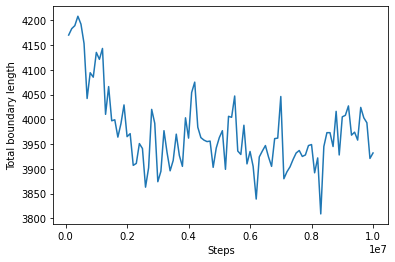

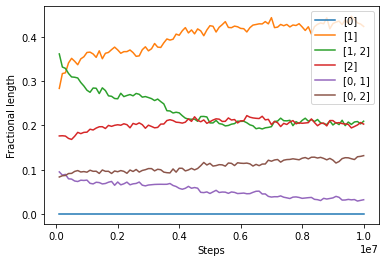

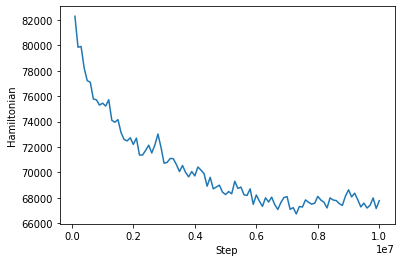

In [163]:
model = Cellular_plots_model(n_steps=10000000, n_types=3, n_cells=100, nx=100, equilibrium_area=36, T=20, lamda=1, k=1, collect_data_steps=100000)
model.run()
model.plot_boundary_lengths()
model.plot_hamiltonian_evolution()

### Multiple runs

Capturing data: 0 of 5
Capturing data: 1 of 5
Capturing data: 2 of 5
Capturing data: 3 of 5
Capturing data: 4 of 5


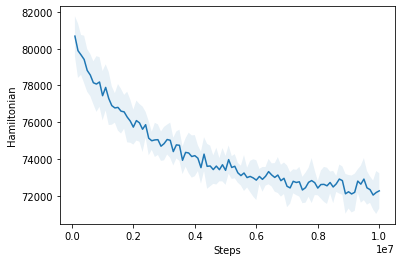

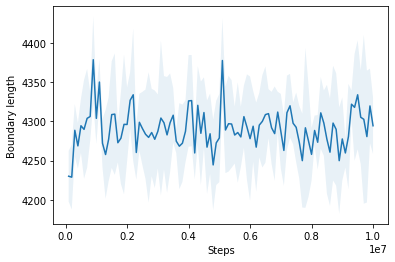

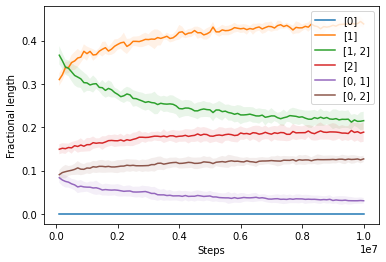

In [164]:
manager = Cellular_potts_manager(n_runs=5, n_steps=10000000, collect_data_steps=100000)
manager.plot_hamiltonian_evolution()
manager.plot_boundary_length_evolution()
manager.plot_fractional_length_evolution()

### Temperature research

In [198]:
def plot_hamiltonian_research(Ts, means, stds):

    fig, ax = plt.subplots()

    ax.plot(Ts, means)
    ax.fill_between(Ts, means - stds, means + stds, alpha=0.1)

    ax.set_xlabel("Temperature")
    ax.set_ylabel("Hamiltonian")

    ax.set_xscale("log")

    plt.show()  

def plot_boundary_research(Ts, means, stds):

    fig, ax = plt.subplots()

    ax.plot(Ts, means)
    ax.fill_between(Ts, means - stds, means + stds, alpha=0.1)

    ax.set_xlabel("Temperature")
    ax.set_ylabel("Boundary length")

    ax.set_xscale("log")

    plt.show() 

def plot_fraction_research(Ts, means, stds, labels):     
    
    fig, ax = plt.subplots()

    # ax.fill_between does not accept 2D y values, therefore an additional loop is used
    for i in range(len(means)):
        
        fractional_means = means[i]
        fractional_stds = stds[i]
        
        ax.plot(Ts, fractional_means, label=labels[i])
        ax.fill_between(Ts, fractional_means - fractional_stds, fractional_means + fractional_stds, alpha=0.1)

    ax.set_xlabel("Temperature")
    ax.set_ylabel("Fractional length")
    
    ax.set_xscale("log")

    plt.legend()
    plt.show() 

In [200]:
# Data gathering

Ts = np.logspace(0, 5, 10)
n_steps = 1000000
n_runs = 5

hamiltonian_means, hamiltonian_stds = [], []
boundary_means, boundary_stds = [], []
fractional_means, fractional_stds = [], []

for T in Ts:
    print(f"T = {T}")
    
    # We are now only interested in the final values of a single run, therefore
    # the data is only collected once at the end
    manager = Cellular_potts_manager(n_runs=n_runs, n_steps=n_steps, collect_data_steps=n_steps, T=T)
    
    hamiltonian_mean, hamiltonian_std = manager.compute_means_and_stds("hamiltonian")
    hamiltonian_means.append(hamiltonian_mean[0])
    hamiltonian_stds.append(hamiltonian_std[0])

    boundary_mean, boundary_std = manager.compute_means_and_stds("boundary_length")
    boundary_means.append(boundary_mean[0])
    boundary_stds.append(boundary_std[0])
    
    fractional_meanss, fractional_stdss = manager.compute_means_and_stds("fractional_length")
    
    fractional_means.append(fractional_meanss[0])
    fractional_stds.append(fractional_stdss[0])
    
    fraction_labels = manager.data[0]["fractional_length_labels"]  

hamiltonian_means, hamiltonian_stds = np.array(hamiltonian_means), np.array(hamiltonian_stds)
boundary_means, boundary_stds = np.array(boundary_means), np.array(boundary_stds)

# Transpose is taken due to the two dimensions
fractional_means, fractional_stds = np.transpose(fractional_means), np.transpose(fractional_stds)

T = 1.0
Capturing data: 0 of 5
Capturing data: 1 of 5
Capturing data: 2 of 5
Capturing data: 3 of 5
Capturing data: 4 of 5
T = 3.5938136638046276
Capturing data: 0 of 5
Capturing data: 1 of 5
Capturing data: 2 of 5
Capturing data: 3 of 5
Capturing data: 4 of 5
T = 12.91549665014884
Capturing data: 0 of 5
Capturing data: 1 of 5
Capturing data: 2 of 5
Capturing data: 3 of 5
Capturing data: 4 of 5
T = 46.4158883361278
Capturing data: 0 of 5
Capturing data: 1 of 5
Capturing data: 2 of 5
Capturing data: 3 of 5
Capturing data: 4 of 5
T = 166.81005372000593
Capturing data: 0 of 5
Capturing data: 1 of 5
Capturing data: 2 of 5
Capturing data: 3 of 5
Capturing data: 4 of 5
T = 599.4842503189409
Capturing data: 0 of 5
Capturing data: 1 of 5
Capturing data: 2 of 5
Capturing data: 3 of 5
Capturing data: 4 of 5
T = 2154.4346900318847
Capturing data: 0 of 5
Capturing data: 1 of 5
Capturing data: 2 of 5
Capturing data: 3 of 5
Capturing data: 4 of 5
T = 7742.636826811277
Capturing data: 0 of 5
Capturin

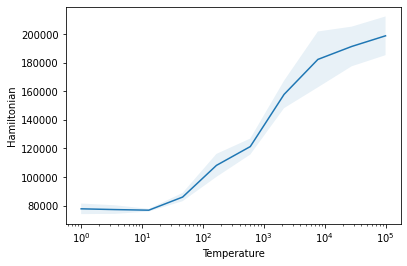

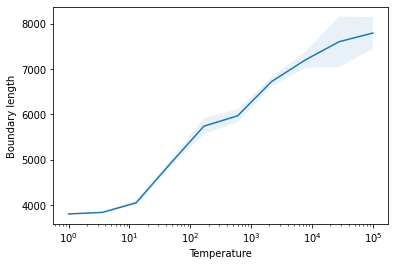

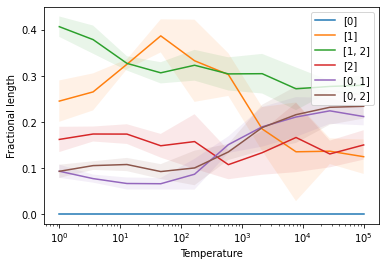

In [199]:
plot_hamiltonian_research(Ts, hamiltonian_means, hamiltonian_stds)
plot_boundary_research(Ts, boundary_means, boundary_stds)
plot_fraction_research(Ts, fractional_means, fractional_stds, fraction_labels)    
